# Individual -Assignment

#### Guillaume GRASSET-GOTHON

In [2]:
import numpy as np
import text_flappy_bird_gym
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

Let's define our own argmax function for a better shuffle

In [3]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = [i]
        elif q_values[i] == top:
            ties.append(i)
    ind = np.random.choice(ties)
    
    return ind

We define the Monte-Carlo based agent

In [4]:
class MonteCarloAgent:
    def __init__(self, env, gamma=0.99):
        """
        Initialize the Monte Carlo Agent.

        Parameters:
        - env: the environment
        - gamma: the discount factor (default: 0.99)
        """
        self.env = env
        self.gamma = gamma
        self.q_values = {}  
        self.returns = {}   
        self.total_rewards = []  

    def select_action(self, state, epsilon):
        """
        Select an action based on the epsilon-greedy policy.

        Parameters:
        - state: the current state
        - epsilon: the exploration rate

        Returns:
        - action: the selected action
        """
        if np.random.rand() < epsilon:
            if self.state_to_tuple(state) not in self.q_values:
                self.q_values[self.state_to_tuple(state)] = np.zeros(self.env.action_space.n)
            return self.env.action_space.sample()
        else:
            return argmax(self.get_q_values(state))
        
    def state_to_tuple(self, state):
        """
        Convert the state to a tuple.

        Parameters:
        - state: the state

        Returns:
        - tuple_state: the state as a tuple
        """
        if type(state) == tuple:
            return state
        elif type(state) == np.ndarray:
            return tuple(state.flatten())
        
    def get_q_values(self, state):
        """
        Get the Q-values for a given state.

        Parameters:
        - state: the state

        Returns:
        - q_values: the Q-values for the state
        """
        if self.state_to_tuple(state) not in self.q_values:
            self.q_values[self.state_to_tuple(state)] = np.zeros(self.env.action_space.n)
        return self.q_values[self.state_to_tuple(state)]

    def run_episode(self, epsilon):
        """
        Run an episode.

        Parameters:
        - epsilon: the exploration rate

        Returns:
        - states: the list of states visited during the episode
        - actions: the list of actions taken during the episode
        - rewards: the list of rewards received during the episode
        - score: the final score of the episode
        """
        states = []
        actions = []
        rewards = []
        state, info = self.env.reset()
        while True:
            action = self.select_action(state, epsilon)
            next_state, reward, done, _ , info= self.env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                break

            state = next_state
        
        return states, actions, rewards, info['score']
    
    def play(self, played_env, epsilon=0):
        """
        Play a game using the learned policy.

        Parameters:
        - epsilon: the exploration rate (default: 0)

        Returns:
        - total_reward: the total reward obtained during the game
        """
        state, _ = played_env.reset()
        score = 0
        actions = []
        states = []
        total_rewards = []
        while True and np.sum(total_rewards) < 1000:
            action = self.select_action(state, epsilon = epsilon)  
            state, reward, done, _ , info = played_env.step(action)
            total_rewards.append(reward)
            score = info['score']
            states.append(state)
            actions.append(action)            
            if done:
                break
        return actions, states, total_rewards, score
    
    def update_q_values(self, states, actions, rewards):
        """
        Update the Q-values based on the observed states, actions, and rewards.

        Parameters:
        - states: the list of observed states
        - actions: the list of observed actions
        - rewards: the list of observed rewards
        """
        returns = 0
        for t in reversed(range(len(states))):
            returns = self.gamma * returns + rewards[t]
            state = states[t]
            action = actions[t]

            if (self.state_to_tuple(state), action) not in self.returns:
                self.returns[(self.state_to_tuple(state), action)] = []

            self.returns[(self.state_to_tuple(state), action)].append(returns)
            self.q_values[self.state_to_tuple(state)][action] = np.mean(self.returns[(self.state_to_tuple(state), action)])
    
    def train(self, num_episodes=1000,epsilon=0.1):
        """
        Train the agent.

        Parameters:
        - num_episodes: the number of episodes to train (default: 1000)
        - epsilon: the exploration rate (default: 0.1)
        """
        self.q_values = {}
        self.returns = {}
        self.total_rewards = []
        # Train the agent through multiple episodes
        for _ in tqdm(range(num_episodes)):
            states, actions, rewards, _ = self.run_episode(epsilon=epsilon)
            self.total_rewards.append(np.sum(rewards))
            self.update_q_values(states, actions, rewards)
    
    def visualize_training_score(self):
        """
        """
        # Plot score
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        # window average
        window = 20
        smooth_total_rewards = [sum(self.total_rewards[i:i+window]) / window for i in range(len(self.total_rewards) - window + 1)]
        plt.plot(smooth_total_rewards)
        # Plot the mean score
        plt.plot([np.mean(self.total_rewards)]*len(self.total_rewards))
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.show()


We first try with the TextFlappyBird-v0 environment

In [5]:
env = gym.make('TextFlappyBird-v0')  
mcagent = MonteCarloAgent(env, gamma=0.9)

100%|██████████| 1500/1500 [00:10<00:00, 139.13it/s]


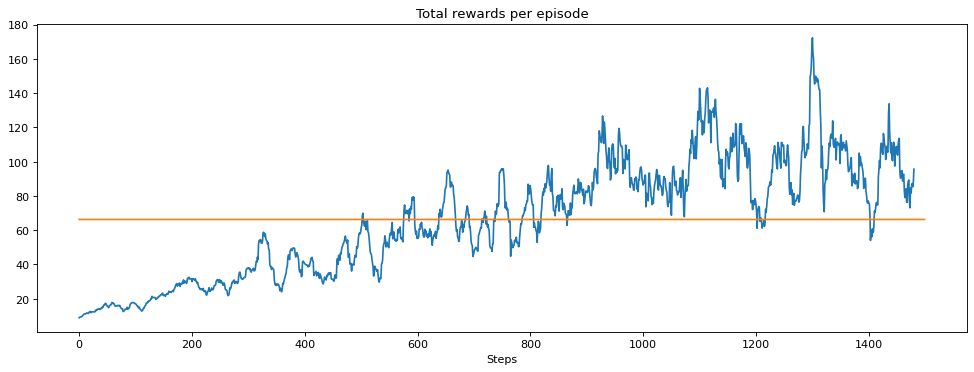

In [6]:
mcagent.train(num_episodes=1500,epsilon=0.1)
mcagent.visualize_training_score()

In [31]:
def plot_state_value_function(agent):
            """Plot the state-value function of the agent

            Args:
                agent (type): Agent object
            """
            states = list(agent.q_values.keys())
            states_x = [state[0] for state in states]
            states_y = [state[1] for state in states]
            x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
            y_vals = np.arange(np.min(states_y), np.max(states_y) + 1, 1)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = np.zeros_like(X)

            for i in range(len(x_vals)):
                for j in range(len(y_vals)):
                    state = (x_vals[i], y_vals[j])
                    # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                    if state in agent.q_values:
                        Z[j, i] = max(agent.q_values[state])
                    else:
                        Z[j, i] = 0 

            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Z, cmap='YlOrRd')
            ax.set_xlabel('Distance on x-axis')
            ax.set_ylabel('Distance on y-axis')
            ax.set_zlabel('State Value')
            ax.set_title('State-Value Function')
            plt.show()


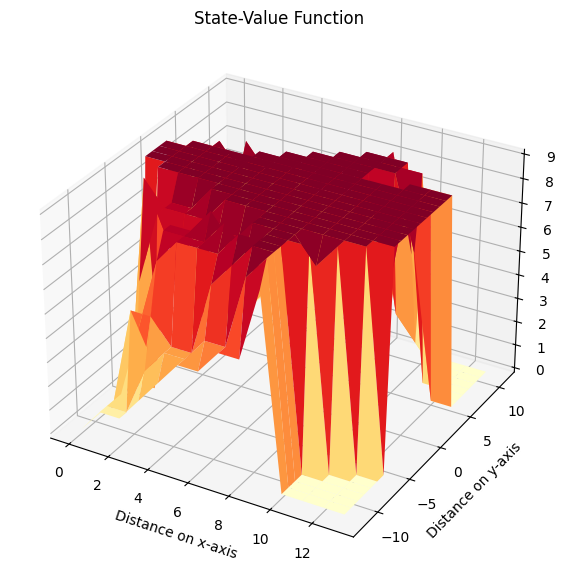

In [26]:
plot_state_value_function(mcagent)

In [27]:
def visualize_state_value_2D(agent):
        """
        """

        # Visualize state values as a 3D scatter plot
        states = list(agent.q_values.keys())
        values = [np.max(agent.q_values[state]) for state in states]
            

        # Get x and y coordinates of states
        x_coords, y_coords = zip(*states)
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

        # Create scatter plot with gradient of color
        plt.scatter(x_coords, y_coords, c=values, cmap='viridis')

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        # Put the y-axis on the right
        plt.gca().yaxis.tick_right()

        # Set labels and title
        plt.xlabel('X-axis (Distance)')
        plt.ylabel('Y-axis (Height)')
        plt.title('State-Value Function (2D Scatter Plot with Gradient of Color)')

        # Show colorbar
        plt.colorbar()

        # Show the plot
        plt.show()
        
def visualize_state_action_2D(agent):
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

        # Visualize state values as a 2D scatter plot
        states = list(agent.q_values.keys())
        values = [np.argmax(agent.q_values[state]) for state in states]

        # Get x and y coordinates of states
        x_coords, y_coords = zip(*states)

        # Create scatter plot
        scatter = plt.scatter(x_coords, y_coords, c=values, cmap='tab10', s=50)

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        # Put the y-axis on the right
        plt.gca().yaxis.tick_right()

        # Set labels and title
        plt.xlabel('X-axis (Distance)')
        plt.ylabel('Y-axis (Height)')
        plt.title('State-Action Function (2D Scatter Plot)')

        # Create a custom legend
        unique_values = np.unique(values)
        legend_labels = [f'Value {val}' for val in unique_values]
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(0), markersize=10, label='flap'),plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(9), markersize=10, label='noflap')]
        plt.legend(handles=legend_handles, loc='upper left')

        # Show the plot
        plt.show()

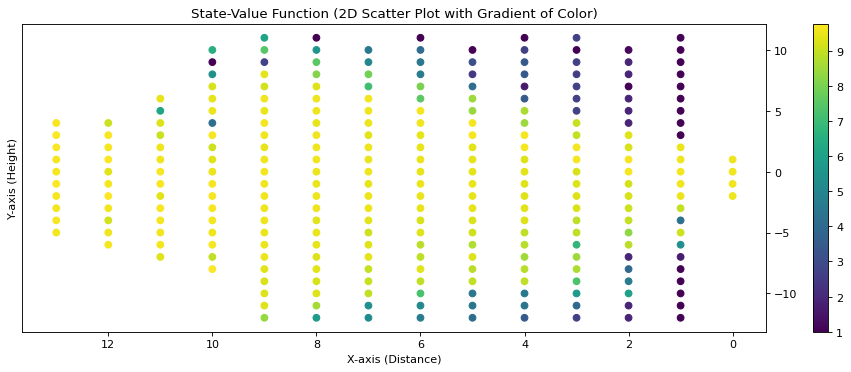

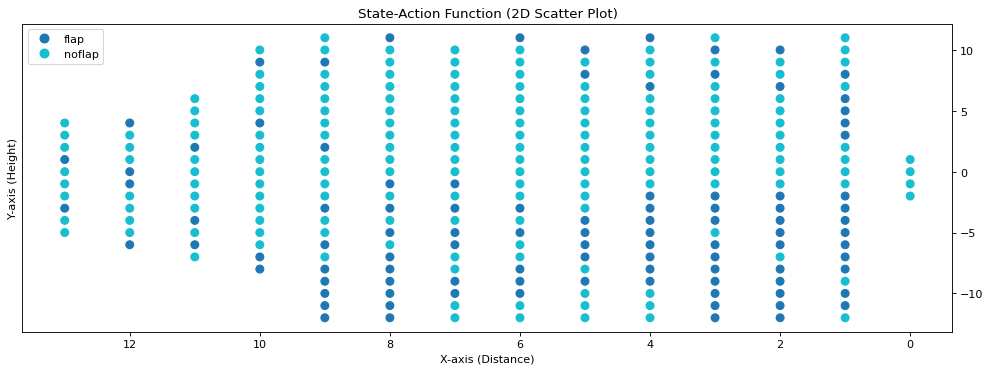

In [28]:
visualize_state_value_2D(mcagent)
visualize_state_action_2D(mcagent)

We got some pretty good results !

Let's try different values for epsilon

100%|██████████| 5000/5000 [00:02<00:00, 1874.41it/s]


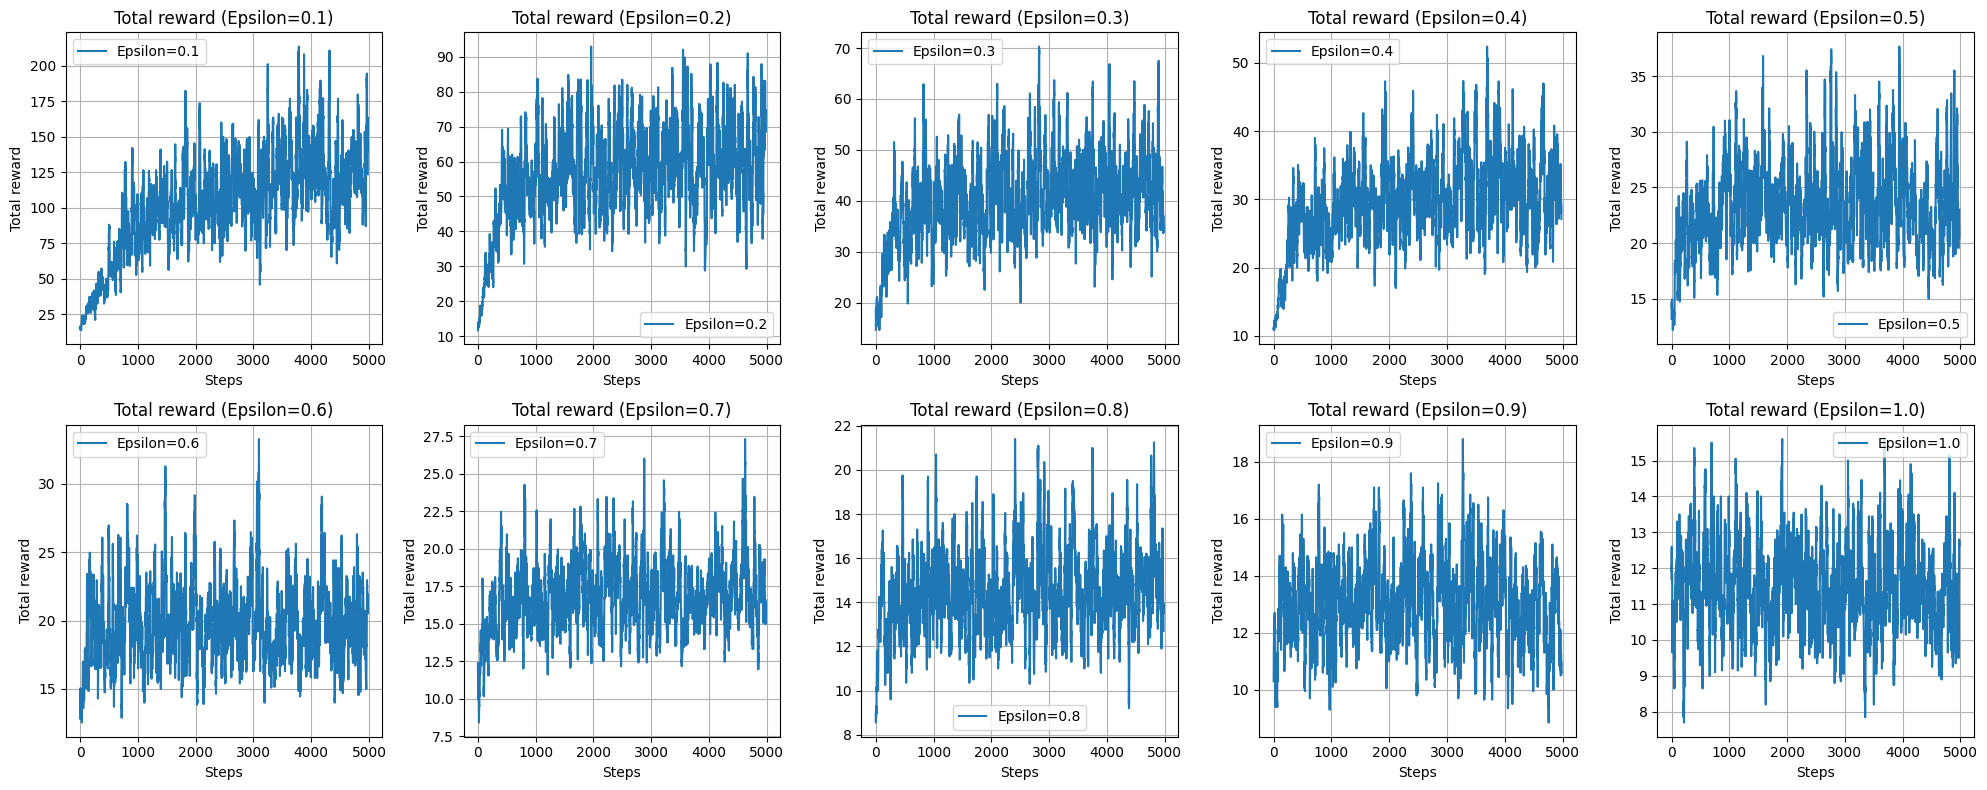

In [31]:
env = gym.make('TextFlappyBird-v0')  
agent = MonteCarloAgent(env, gamma=0.9)

step_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_total_rewards = {step_size: [] for step_size in step_sizes}
window = 20
for epsilon in step_sizes:
    agent.train(num_episodes=5000, epsilon=epsilon)
    smooth_total_rewards = [sum(agent.total_rewards[i:i+window]) / window for i in range(len(agent.total_rewards) - window + 1)]
    n_total_rewards[epsilon] = smooth_total_rewards

fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, epsilon in enumerate(step_sizes):
    row = i // 5  
    col = i % 5  
    axs[row, col].plot(n_total_rewards[epsilon], label=f"Epsilon={epsilon}")
    axs[row, col].set_title(f"Total reward (Epsilon={epsilon})")
    axs[row, col].set_xlabel("Steps")
    axs[row, col].set_ylabel("Total reward")
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.tight_layout()
plt.show()

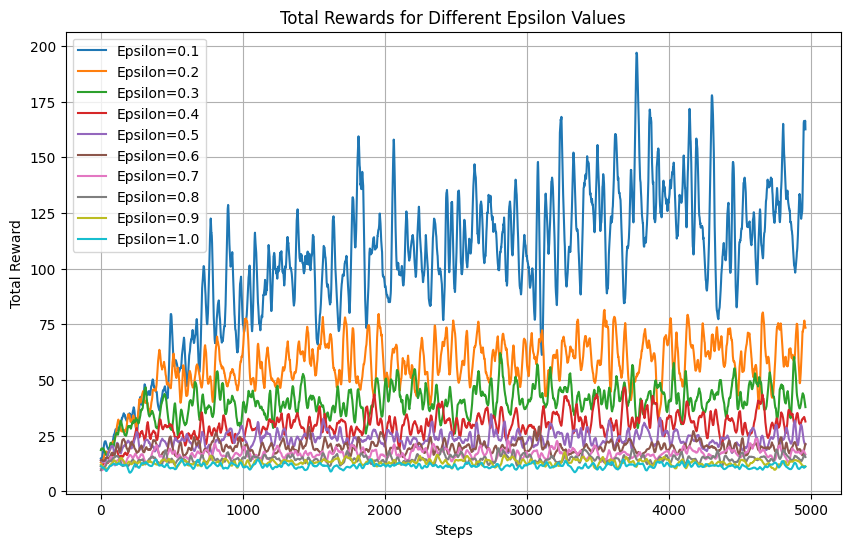

In [34]:
env = gym.make('TextFlappyBird-v0')  
fig, ax = plt.subplots(figsize=(10, 6))
n_smooth_total_rewards = {step_size: [] for step_size in step_sizes}

for epsilon in step_sizes:
    smooth_total_rewards = [sum(n_total_rewards[epsilon][i:i+window]) / window for i in range(len(n_total_rewards[epsilon]) - window + 1)]
    n_smooth_total_rewards[epsilon] = smooth_total_rewards
    ax.plot(n_smooth_total_rewards[epsilon], label=f"Epsilon={epsilon}")

ax.set_title("Total Rewards for Different Epsilon Values")
ax.set_xlabel("Steps")
ax.set_ylabel("Total Reward")
ax.legend()
ax.grid(True)

plt.show()

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:15<00:00, 95.82it/s]


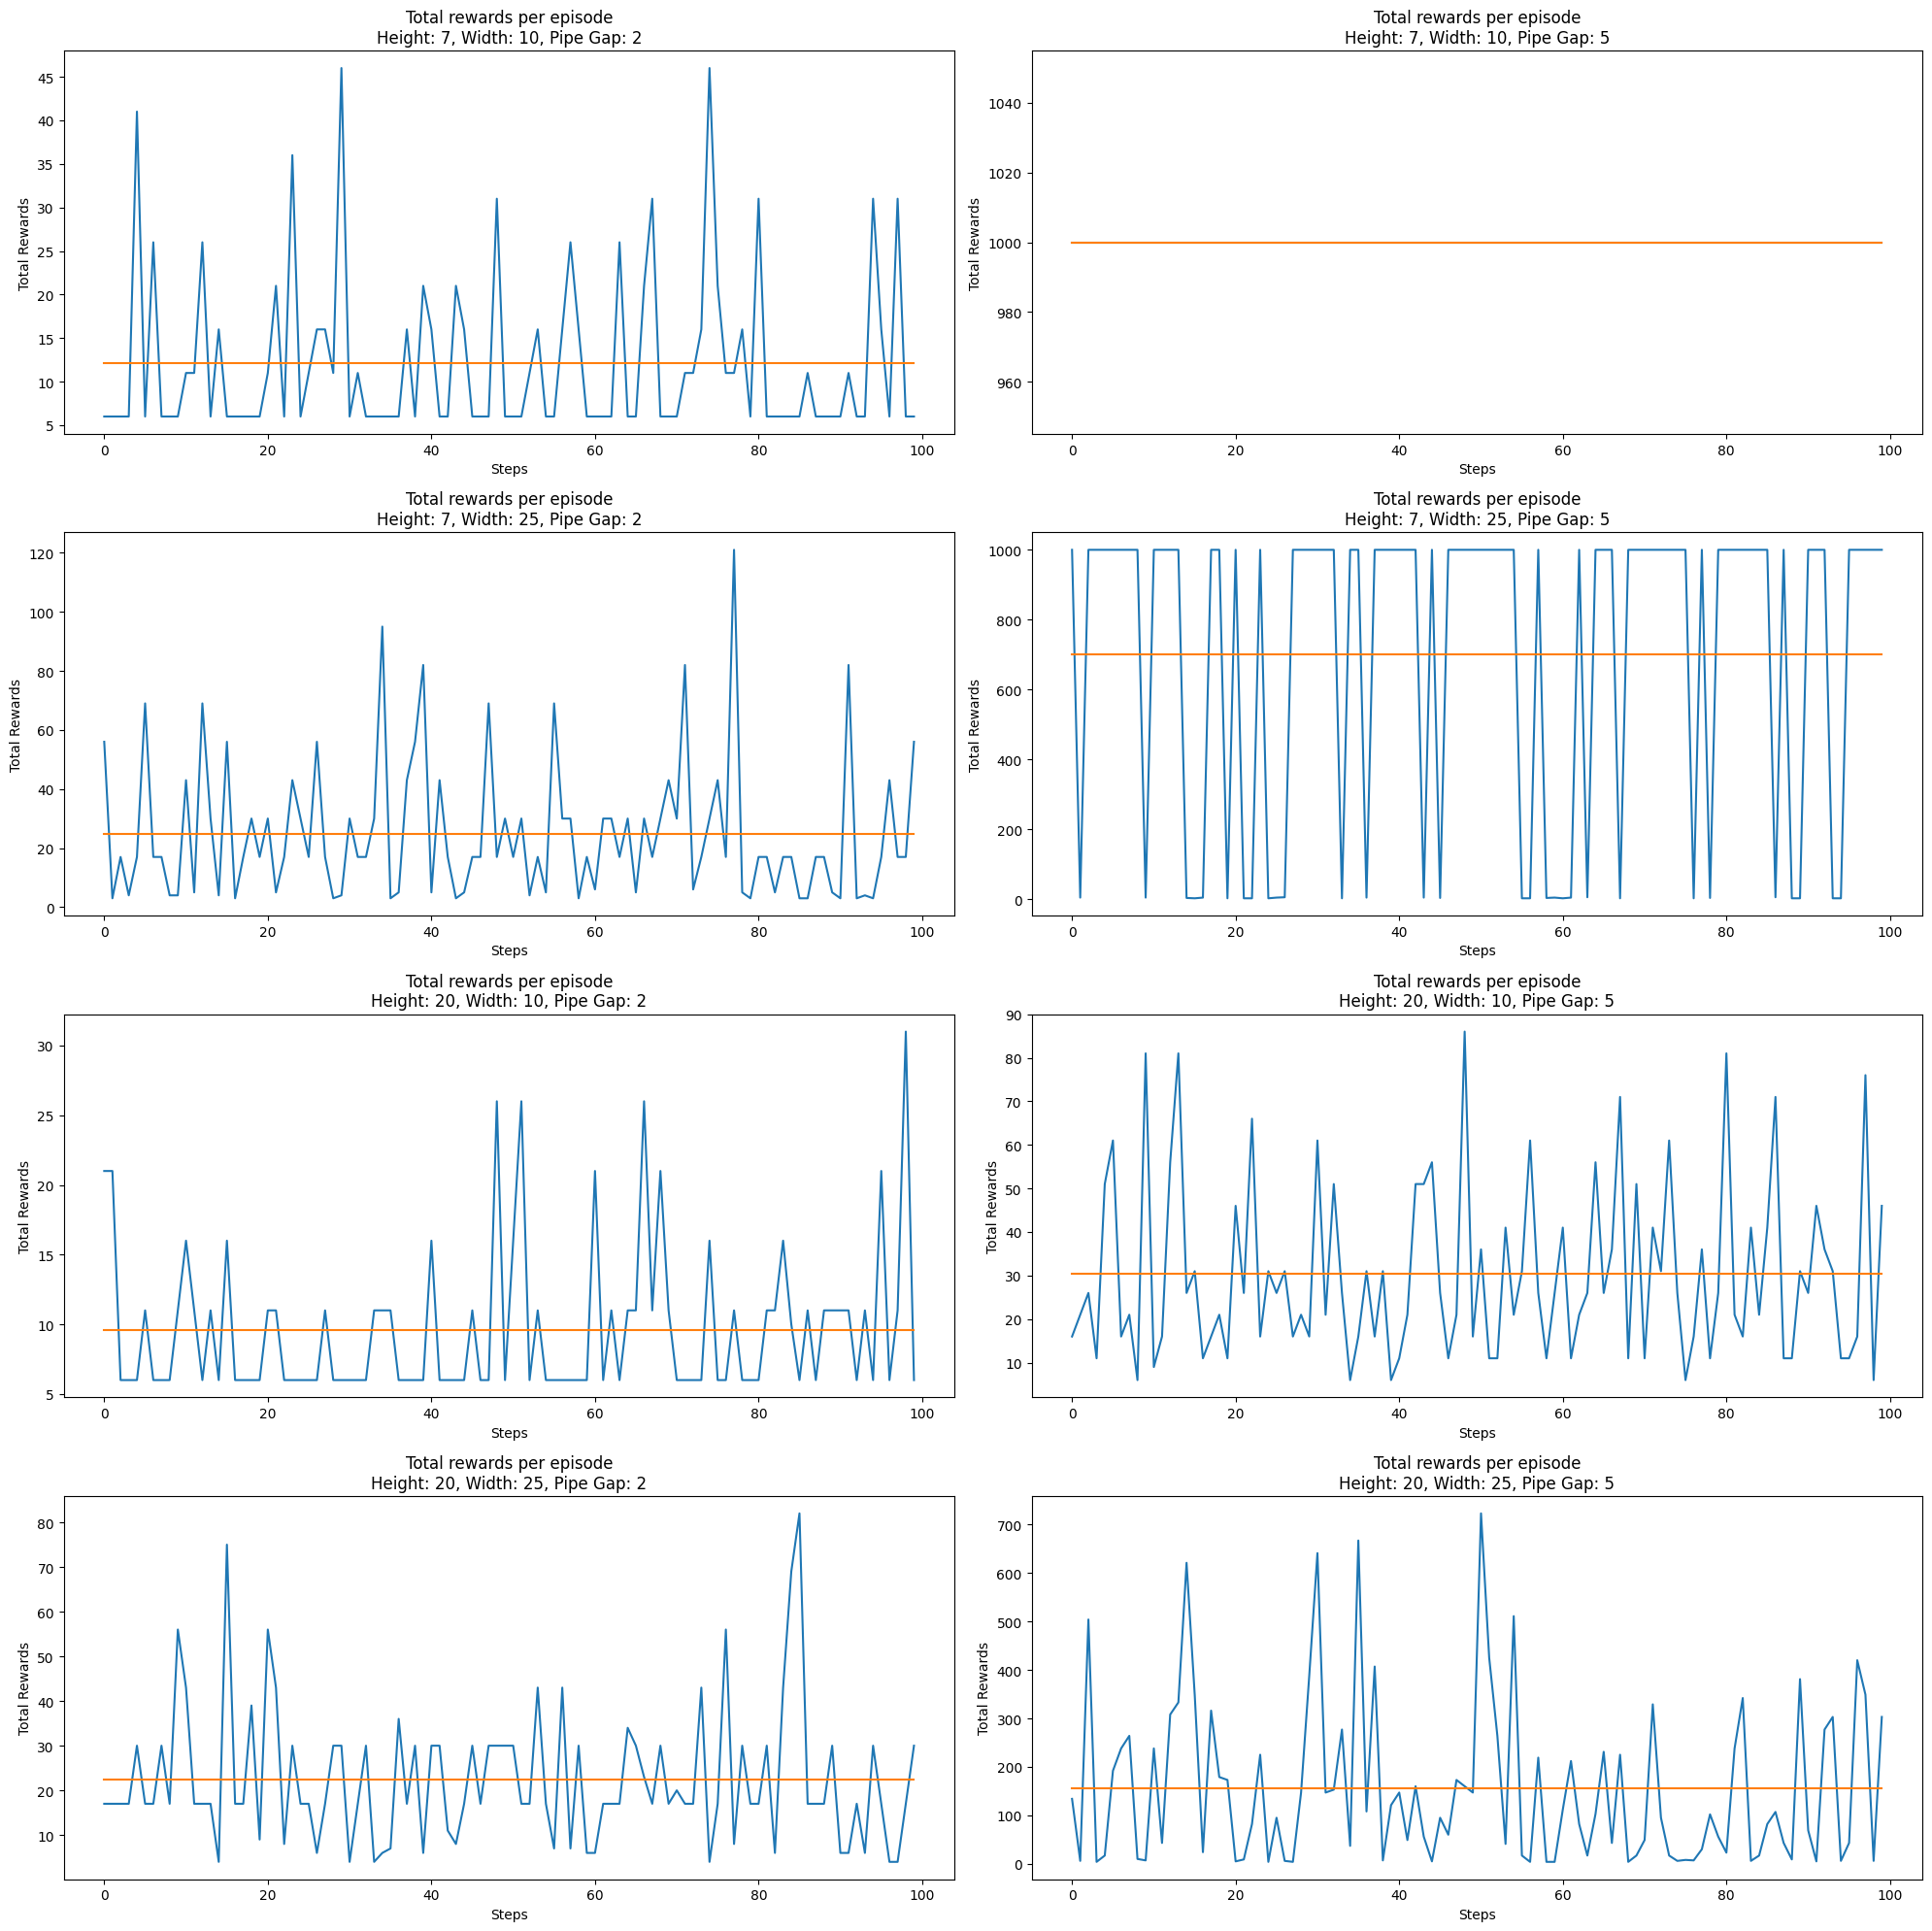

In [12]:
env = gym.make('TextFlappyBird-v0')  
mcagent = MonteCarloAgent(env, gamma=0.9)
mcagent.train(num_episodes=1500, epsilon=0.1)
heights = [7, 20]
widths = [10, 25]
pipe_gaps = [2, 5]

fig, axs = plt.subplots(4, 2, figsize=(20, 20))

for i, (height, width, pipe_gap) in enumerate(itertools.product(heights, widths, pipe_gaps)):
    played_env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
    n_total_rewards = []
    try:
        for _ in range(100):
            actions, states, total_rewards, score = mcagent.play(played_env, epsilon=0)
            n_total_rewards.append(np.sum(total_rewards))
        
        row = i // 2
        col = i % 2
        axs[row, col].plot(n_total_rewards)
        axs[row, col].plot([np.mean(n_total_rewards)]*len(n_total_rewards))
        axs[row, col].set_title("Total rewards per episode\nHeight: {}, Width: {}, Pipe Gap: {}".format(height, width, pipe_gap))
        axs[row, col].set_xlabel("Steps")
        axs[row, col].set_ylabel("Total Rewards")
    except:
        print("Error with height: {}, width: {}, pipe_gap: {}".format(height, width, pipe_gap))
        continue

plt.tight_layout()
plt.show()


## Lambda Sarsa Agent

In this section, we will implement the Sarsa Agent.

The first agent is ooded for a tuple

In [2]:
class SarsaLambda:
    def __init__(self, env, alpha, gamma, lambd):
        """
        Initialize Sarsa Lambda agent with environment, learning rate, discount factor, and lambda
        """
        self.env = env
        self.num_states_x = env.observation_space[0].n 
        self.num_states_y = env.observation_space[1].n 
        self.num_actions = env.action_space.n
        self.alpha = alpha
        self.gamma = gamma
        self.lambd = lambd
        self.Q = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  # Initialize Q-table
        self.E = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  # Initialize Eligibility traces
        self.actions = np.arange(self.num_actions)  # Possible actions
        self.total_rewards = []  # Store total rewards per episode
    
    def select_action(self, state, epsilon):
        """
        Epsilon-greedy action selection
        """
        if np.random.rand() < epsilon:
            return np.random.choice(self.actions)  # Choose a random action
        else:
            return np.argmax(self.Q[state[0], state[1] + 9, :])  # Choose the action with highest Q-value
    
    def update_q(self, state, action, reward, next_state, next_action):
        """
        Update Q-values using Sarsa(λ) algorithm
        """
        delta = reward + self.gamma * self.Q[next_state[0], next_state[1] + 9, next_action] - self.Q[state[0], state[1] + 9 , action]
        self.E[state[0], state[1] + 9, action] += 1  # Update Eligibility traces
        for sx in range(self.num_states_x):
            for sy in range(self.num_states_y):
                for a in range(self.num_actions):
                    self.Q[sx, sy, a] += self.alpha * delta * self.E[sx, sy, a]  # Update Q-value
                    self.E[sx, sy, a] *= self.gamma * self.lambd  # Decay Eligibility traces

    def run_episode(self, epsilon):
        """
        Run one episode of the environment
        """
        states = []
        actions = []
        rewards = []
        self.E = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))  
        state, _ = self.env.reset()
        action = self.select_action(state, epsilon)

        while True:
            next_state, reward, done, _, _ = self.env.step(action)
            next_action = self.select_action(next_state, epsilon)
            self.update_q(state, action, reward, next_state, next_action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            state = next_state
            action = next_action

            if done:
                break

            state = next_state
        return states, actions, rewards

    def play(self, epsilon=0):
        """
        Play the environment using the learned policy
        """
        state, _ = self.env.reset()
        total_reward = 0
        while True and total_reward < 1000:
            action = self.select_action(state, epsilon=epsilon) 
            state, reward, done, _, _ = self.env.step(action)
            total_reward += reward
            if done:
                break
        return total_reward
    
    def train(self, num_episodes, epsilon=0.1):
        """
        Train the agent for a given number of episodes
        """
        self.Q = np.zeros((self.num_states_x, self.num_states_y, self.num_actions))
        self.total_rewards = []
        for _ in tqdm(range(num_episodes)):
            _, _, rewards = self.run_episode(epsilon=epsilon)
            self.total_rewards.append(np.sum(rewards))
        return self.total_rewards
    
    def plot_value_function(self):
        """
        Plot the value function
        """
        plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
        plt.plot(self.total_rewards)
        plt.plot([np.mean(self.total_rewards)] * len(self.total_rewards))  
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.show()
        states = list(itertools.product(range(self.num_states_x), range(self.num_states_y)))
        values = [np.max(self.Q[state[0], state[1], :]) for state in states]

        try:
            states = list(self.q_values.keys())
            values = [np.max(self.q_values[state]) for state in states]

            # Get x and y coordinates of states
            x_coords, y_coords = zip(*states)
            plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

             # Create scatter plot with gradient of color
            plt.scatter(x_coords, y_coords, c=values, cmap='viridis')

            # Reverse the x-axis
            plt.gca().invert_xaxis()

            # Put the y-axis on the right
            plt.gca().yaxis.tick_right()

            # Set labels and title
            plt.xlabel('X-axis (Distance)')
            plt.ylabel('Y-axis (Height)')
            plt.title('State-Value Function (2D Scatter Plot with Gradient of Color)')

            # Show colorbar
            plt.colorbar()

            # Show the plot
            plt.show()
        except:
            pass
            
    def visualize_training_score(self):
        # Plot score
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
        # window average
        window = 20
        smooth_total_rewards = [sum(self.total_rewards[i:i+window]) / window for i in range(len(self.total_rewards) - window + 1)]
        plt.plot(smooth_total_rewards)
        # Plot the mean score
        plt.plot([np.mean(self.total_rewards)]*len(self.total_rewards))
        plt.title("Total rewards per episode")
        plt.xlabel("Steps")
        plt.show()


  0%|          | 13/5000 [00:00<00:38, 128.72it/s]

100%|██████████| 5000/5000 [03:36<00:00, 23.14it/s] 


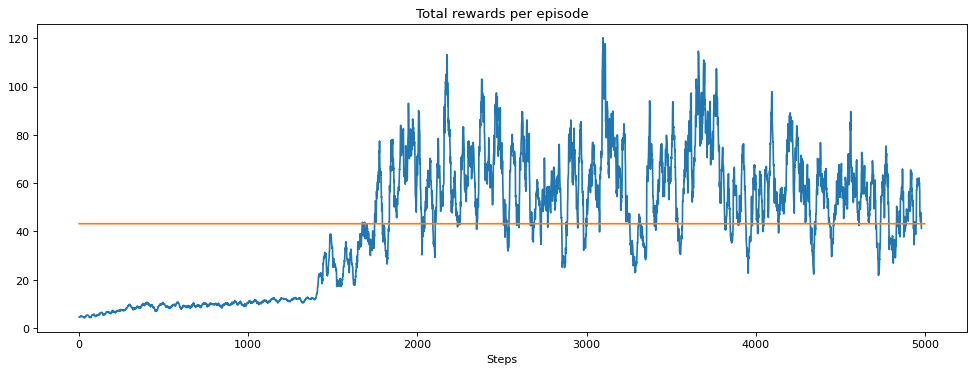

In [3]:
#Best Parameters: (0.1, 0.4, 0.99, 0.6),

# Example usage:
env = gym.make('TextFlappyBird-v0')
epsilon = 0.1
alpha = 0.4
gamma = 0.99
lambd = 0.6

sarsa_agent = SarsaLambda(env, alpha, gamma, lambd)
sarsa_agent.train(num_episodes=5000, epsilon=epsilon)
sarsa_agent.visualize_training_score()

In [8]:
def plot_state_value_function(agent):
            """Plot the state-value function of the agent

            Args:
                agent (type): Agent object
            """
            result_dict = {(i, j): agent.Q[i, j].tolist() for i in range(agent.Q.shape[0]) for j in range(agent.Q.shape[1])}
            states = list(result_dict.keys())
            states_x = [state[0] for state in states]
            states_y = [state[1] for state in states]
            x_vals = np.arange(np.min(states_x), np.max(states_x) + 1, 1)
            y_vals = np.arange(np.min(states_y) - 12, np.max(states_y) + 1 - 12, 1)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = np.zeros_like(X)

            for i in range(len(x_vals)):
                for j in range(len(y_vals)):
                    state = (x_vals[i], y_vals[j]+12)
                    # If the state is in the Q-table, take the maximum Q-value for the state, else 0
                    if state in result_dict:
                        Z[j, i] = max(agent.Q[state])
                    else:
                        Z[j, i] = 0 

            fig = plt.figure(figsize=(10, 7))
            ax = fig.add_subplot(111, projection='3d')
            ax.plot_surface(X, Y, Z, cmap='YlOrRd')
            ax.set_xlabel('Distance on x-axis')
            ax.set_ylabel('Distance on y-axis')
            ax.set_zlabel('State Value')
            ax.set_title('State-Value Function')
            plt.show()

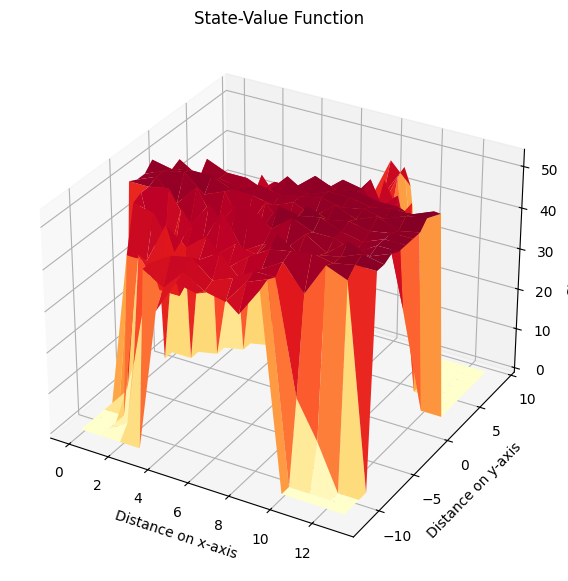

In [9]:
plot_state_value_function(sarsa_agent)

In [6]:
def visualize_state_value_2D(agent):
        """
        """

        # Visualize state values as a 3D scatter plot
        result_dict = {(i, j): agent.Q[i, j].tolist() for i in range(agent.Q.shape[0]) for j in range(agent.Q.shape[1])}

        # Visualize state values as a 3D scatter plot
        states = list(result_dict.keys())
        values = [np.max(result_dict[state]) for state in states]

        # Get x and y coordinates of states
        x_coords, y_coords = zip(*states)
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

        # Create scatter plot with gradient of color
        plt.scatter(x_coords, y_coords, c=values, cmap='viridis')

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        # Put the y-axis on the right
        plt.gca().yaxis.tick_right()

        # Set labels and title
        plt.xlabel('X-axis (Distance)')
        plt.ylabel('Y-axis (Height)')
        plt.title('State-Value Function (2D Scatter Plot with Gradient of Color)')

        # Show colorbar
        plt.colorbar()

        # Show the plot
        plt.show()
        
def visualize_state_action_2D(agent):
        plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

        # Visualize state values as a 3D scatter plot
        result_dict = {(i, j): agent.Q[i, j].tolist() for i in range(agent.Q.shape[0]) for j in range(agent.Q.shape[1])}

        # Visualize state values as a 3D scatter plot
        states = list(result_dict.keys())
        values = [np.argmax(result_dict[state]) for state in states]

        # Get x and y coordinates of states
        x_coords, y_coords = zip(*states)

        # Create scatter plot
        scatter = plt.scatter(x_coords, y_coords, c=values, cmap='tab10', s=50)

        # Reverse the x-axis
        plt.gca().invert_xaxis()

        # Put the y-axis on the right
        plt.gca().yaxis.tick_right()

        # Set labels and title
        plt.xlabel('X-axis (Distance)')
        plt.ylabel('Y-axis (Height)')
        plt.title('State-Value Function (2D Scatter Plot)')

        # Create a custom legend
        unique_values = np.unique(values)
        legend_labels = [f'Value {val}' for val in unique_values]
        legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(0), markersize=10, label='flap'),plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.cm.tab10(9), markersize=10, label='noflap')]
        plt.legend(handles=legend_handles, loc='upper left')

        # Show the plot
        plt.show()

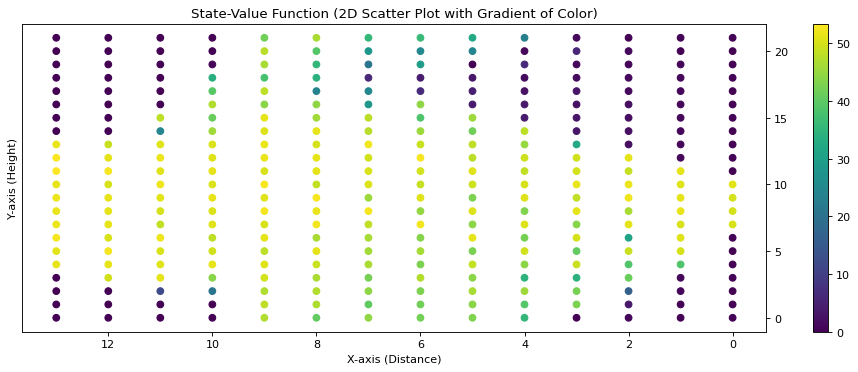

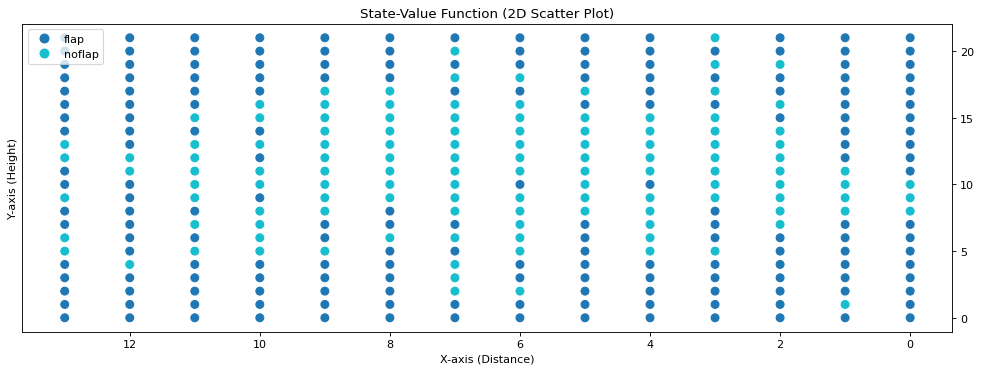

In [7]:
visualize_state_value_2D(sarsa_agent)
visualize_state_action_2D(sarsa_agent)

We optimize the parameters to improve the Agent

In [36]:
import math

env = gym.make('TextFlappyBird-v0')

# Define the ranges for each parameter
epsilon_values = [0.1, 0.3, 0.5,0.8]
alpha_values = [ 0.2,0.4, 0.5, 0.6, 0.8]
gamma_values = [0.9, 0.95, 0.99]
lambd_values = [0.6,0.8, 0.9, 1.0]

results = {}

best_params = None
best_performance = -math.inf


# Perform the grid search
for epsilon, alpha, gamma, lambd in itertools.product(epsilon_values, alpha_values, gamma_values, lambd_values):
    # Create and train the agent with the current set of parameters
    sarsa_agent = SarsaLambda(env, alpha, gamma, lambd)
    sarsa_agent.train(num_episodes=2500, epsilon=epsilon)

    # Check if the current set of parameters resulted in the best performance
    if np.mean(sarsa_agent.total_rewards[-500]) > best_performance:
        best_params = (epsilon, alpha, gamma, lambd)
        best_performance = sarsa_agent.total_rewards[-1]
    print(
          f"Current Parameters: ({epsilon}, {alpha}, {gamma}, {lambd}), Performance: {np.mean(sarsa_agent.total_rewards[-500]):.2f}"
          
          f"Best Parameters: {best_params}, Best Performance: {best_performance:.2f}")
    results[(epsilon, alpha, gamma, lambd)] = sarsa_agent.total_rewards


  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [00:34<00:00, 72.21it/s] 


Current Parameters: (0.1, 0.2, 0.9, 0.6), Performance: 10.00Best Parameters: (0.1, 0.2, 0.9, 0.6), Best Performance: 4.00


100%|██████████| 2500/2500 [00:27<00:00, 92.10it/s] 


Current Parameters: (0.1, 0.2, 0.9, 0.8), Performance: 13.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:26<00:00, 93.59it/s] 


Current Parameters: (0.1, 0.2, 0.9, 0.9), Performance: 13.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:26<00:00, 93.33it/s] 


Current Parameters: (0.1, 0.2, 0.9, 1.0), Performance: 13.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:34<00:00, 72.21it/s] 


Current Parameters: (0.1, 0.2, 0.95, 0.6), Performance: 13.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [01:03<00:00, 39.60it/s]


Current Parameters: (0.1, 0.2, 0.95, 0.8), Performance: 5.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:25<00:00, 97.68it/s] 


Current Parameters: (0.1, 0.2, 0.95, 0.9), Performance: 12.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:32<00:00, 77.81it/s]


Current Parameters: (0.1, 0.2, 0.95, 1.0), Performance: 4.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:24<00:00, 100.69it/s]


Current Parameters: (0.1, 0.2, 0.99, 0.6), Performance: 13.00Best Parameters: (0.1, 0.2, 0.9, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:35<00:00, 70.47it/s] 


Current Parameters: (0.1, 0.2, 0.99, 0.8), Performance: 21.00Best Parameters: (0.1, 0.2, 0.99, 0.8), Best Performance: 58.00


100%|██████████| 2500/2500 [00:26<00:00, 95.28it/s] 


Current Parameters: (0.1, 0.2, 0.99, 0.9), Performance: 10.00Best Parameters: (0.1, 0.2, 0.99, 0.8), Best Performance: 58.00


100%|██████████| 2500/2500 [00:34<00:00, 72.93it/s] 


Current Parameters: (0.1, 0.2, 0.99, 1.0), Performance: 20.00Best Parameters: (0.1, 0.2, 0.99, 0.8), Best Performance: 58.00


100%|██████████| 2500/2500 [01:33<00:00, 26.79it/s]


Current Parameters: (0.1, 0.4, 0.9, 0.6), Performance: 14.00Best Parameters: (0.1, 0.2, 0.99, 0.8), Best Performance: 58.00


100%|██████████| 2500/2500 [01:26<00:00, 28.93it/s]


Current Parameters: (0.1, 0.4, 0.9, 0.8), Performance: 13.00Best Parameters: (0.1, 0.2, 0.99, 0.8), Best Performance: 58.00


100%|██████████| 2500/2500 [01:02<00:00, 40.26it/s]


Current Parameters: (0.1, 0.4, 0.9, 0.9), Performance: 83.00Best Parameters: (0.1, 0.4, 0.9, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [01:18<00:00, 31.99it/s]


Current Parameters: (0.1, 0.4, 0.9, 1.0), Performance: 23.00Best Parameters: (0.1, 0.4, 0.9, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [01:45<00:00, 23.78it/s]


Current Parameters: (0.1, 0.4, 0.95, 0.6), Performance: 57.00Best Parameters: (0.1, 0.4, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [01:26<00:00, 28.95it/s]


Current Parameters: (0.1, 0.4, 0.95, 0.8), Performance: 63.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:14<00:00, 33.37it/s]


Current Parameters: (0.1, 0.4, 0.95, 0.9), Performance: 29.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:07<00:00, 36.86it/s]


Current Parameters: (0.1, 0.4, 0.95, 1.0), Performance: 33.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:20<00:00, 31.14it/s]


Current Parameters: (0.1, 0.4, 0.99, 0.6), Performance: 113.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:23<00:00, 29.78it/s]


Current Parameters: (0.1, 0.4, 0.99, 0.8), Performance: 81.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:38<00:00, 25.36it/s]


Current Parameters: (0.1, 0.4, 0.99, 0.9), Performance: 38.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:44<00:00, 56.05it/s]


Current Parameters: (0.1, 0.4, 0.99, 1.0), Performance: 13.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:19<00:00, 31.34it/s]


Current Parameters: (0.1, 0.5, 0.9, 0.6), Performance: 93.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:38<00:00, 25.45it/s]


Current Parameters: (0.1, 0.5, 0.9, 0.8), Performance: 53.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:16<00:00, 32.78it/s]


Current Parameters: (0.1, 0.5, 0.9, 0.9), Performance: 6.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:15<00:00, 33.18it/s]


Current Parameters: (0.1, 0.5, 0.9, 1.0), Performance: 18.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:31<00:00, 27.46it/s]


Current Parameters: (0.1, 0.5, 0.95, 0.6), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:31<00:00, 27.21it/s]


Current Parameters: (0.1, 0.5, 0.95, 0.8), Performance: 63.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:43<00:00, 24.23it/s]


Current Parameters: (0.1, 0.5, 0.95, 0.9), Performance: 31.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:16<00:00, 32.48it/s]


Current Parameters: (0.1, 0.5, 0.95, 1.0), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:35<00:00, 26.23it/s]


Current Parameters: (0.1, 0.5, 0.99, 0.6), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:35<00:00, 26.12it/s]


Current Parameters: (0.1, 0.5, 0.99, 0.8), Performance: 53.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:30<00:00, 27.68it/s]


Current Parameters: (0.1, 0.5, 0.99, 0.9), Performance: 85.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:39<00:00, 62.85it/s]


Current Parameters: (0.1, 0.5, 0.99, 1.0), Performance: 13.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:35<00:00, 26.29it/s]


Current Parameters: (0.1, 0.6, 0.9, 0.6), Performance: 32.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:46<00:00, 23.54it/s]


Current Parameters: (0.1, 0.6, 0.9, 0.8), Performance: 24.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:31<00:00, 27.22it/s]


Current Parameters: (0.1, 0.6, 0.9, 0.9), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:24<00:00, 29.60it/s]


Current Parameters: (0.1, 0.6, 0.9, 1.0), Performance: 20.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:36<00:00, 25.90it/s]


Current Parameters: (0.1, 0.6, 0.95, 0.6), Performance: 67.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:39<00:00, 25.12it/s]


Current Parameters: (0.1, 0.6, 0.95, 0.8), Performance: 43.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:32<00:00, 27.02it/s]


Current Parameters: (0.1, 0.6, 0.95, 0.9), Performance: 9.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:06<00:00, 37.67it/s]


Current Parameters: (0.1, 0.6, 0.95, 1.0), Performance: 24.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:45<00:00, 23.62it/s]


Current Parameters: (0.1, 0.6, 0.99, 0.6), Performance: 41.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:28<00:00, 28.17it/s]


Current Parameters: (0.1, 0.6, 0.99, 0.8), Performance: 98.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:13<00:00, 33.89it/s]


Current Parameters: (0.1, 0.6, 0.99, 0.9), Performance: 27.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:37<00:00, 67.53it/s]


Current Parameters: (0.1, 0.6, 0.99, 1.0), Performance: 21.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:37<00:00, 25.76it/s]


Current Parameters: (0.1, 0.8, 0.9, 0.6), Performance: 9.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:32<00:00, 27.08it/s]


Current Parameters: (0.1, 0.8, 0.9, 0.8), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:24<00:00, 29.60it/s]


Current Parameters: (0.1, 0.8, 0.9, 0.9), Performance: 48.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:07<00:00, 37.24it/s]


Current Parameters: (0.1, 0.8, 0.9, 1.0), Performance: 54.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:37<00:00, 25.60it/s]


Current Parameters: (0.1, 0.8, 0.95, 0.6), Performance: 7.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:31<00:00, 27.19it/s]


Current Parameters: (0.1, 0.8, 0.95, 0.8), Performance: 18.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:19<00:00, 31.34it/s]


Current Parameters: (0.1, 0.8, 0.95, 0.9), Performance: 7.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:55<00:00, 45.39it/s]


Current Parameters: (0.1, 0.8, 0.95, 1.0), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:39<00:00, 25.22it/s]


Current Parameters: (0.1, 0.8, 0.99, 0.6), Performance: 104.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:29<00:00, 27.81it/s]


Current Parameters: (0.1, 0.8, 0.99, 0.8), Performance: 74.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:14<00:00, 33.49it/s]


Current Parameters: (0.1, 0.8, 0.99, 0.9), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:34<00:00, 72.40it/s]


Current Parameters: (0.1, 0.8, 0.99, 1.0), Performance: 43.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:56<00:00, 44.44it/s]


Current Parameters: (0.3, 0.2, 0.9, 0.6), Performance: 9.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:03<00:00, 39.17it/s]


Current Parameters: (0.3, 0.2, 0.9, 0.8), Performance: 9.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:01<00:00, 40.88it/s]


Current Parameters: (0.3, 0.2, 0.9, 0.9), Performance: 13.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:58<00:00, 42.80it/s]


Current Parameters: (0.3, 0.2, 0.9, 1.0), Performance: 52.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:01<00:00, 40.70it/s]


Current Parameters: (0.3, 0.2, 0.95, 0.6), Performance: 8.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:09<00:00, 35.92it/s]


Current Parameters: (0.3, 0.2, 0.95, 0.8), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:56<00:00, 44.21it/s]


Current Parameters: (0.3, 0.2, 0.95, 0.9), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:57<00:00, 43.22it/s]


Current Parameters: (0.3, 0.2, 0.95, 1.0), Performance: 10.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:01<00:00, 40.53it/s]


Current Parameters: (0.3, 0.2, 0.99, 0.6), Performance: 26.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:07<00:00, 36.90it/s]


Current Parameters: (0.3, 0.2, 0.99, 0.8), Performance: 27.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:02<00:00, 39.80it/s]


Current Parameters: (0.3, 0.2, 0.99, 0.9), Performance: 18.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:56<00:00, 44.45it/s]


Current Parameters: (0.3, 0.2, 0.99, 1.0), Performance: 17.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:12<00:00, 34.33it/s]


Current Parameters: (0.3, 0.4, 0.9, 0.6), Performance: 83.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:08<00:00, 36.30it/s]


Current Parameters: (0.3, 0.4, 0.9, 0.8), Performance: 28.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:01<00:00, 40.35it/s]


Current Parameters: (0.3, 0.4, 0.9, 0.9), Performance: 28.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:58<00:00, 42.99it/s]


Current Parameters: (0.3, 0.4, 0.9, 1.0), Performance: 41.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:09<00:00, 35.75it/s]


Current Parameters: (0.3, 0.4, 0.95, 0.6), Performance: 12.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:05<00:00, 37.90it/s]


Current Parameters: (0.3, 0.4, 0.95, 0.8), Performance: 21.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:02<00:00, 40.12it/s]


Current Parameters: (0.3, 0.4, 0.95, 0.9), Performance: 63.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:56<00:00, 44.35it/s]


Current Parameters: (0.3, 0.4, 0.95, 1.0), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:08<00:00, 36.27it/s]


Current Parameters: (0.3, 0.4, 0.99, 0.6), Performance: 24.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:05<00:00, 38.03it/s]


Current Parameters: (0.3, 0.4, 0.99, 0.8), Performance: 8.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:59<00:00, 42.32it/s]


Current Parameters: (0.3, 0.4, 0.99, 0.9), Performance: 12.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:51<00:00, 48.89it/s]


Current Parameters: (0.3, 0.4, 0.99, 1.0), Performance: 13.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:07<00:00, 36.77it/s]


Current Parameters: (0.3, 0.5, 0.9, 0.6), Performance: 16.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:05<00:00, 38.26it/s]


Current Parameters: (0.3, 0.5, 0.9, 0.8), Performance: 16.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:00<00:00, 41.64it/s]


Current Parameters: (0.3, 0.5, 0.9, 0.9), Performance: 28.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:59<00:00, 42.15it/s]


Current Parameters: (0.3, 0.5, 0.9, 1.0), Performance: 14.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:06<00:00, 37.68it/s]


Current Parameters: (0.3, 0.5, 0.95, 0.6), Performance: 4.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:05<00:00, 38.13it/s]


Current Parameters: (0.3, 0.5, 0.95, 0.8), Performance: 23.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:59<00:00, 41.67it/s]


Current Parameters: (0.3, 0.5, 0.95, 0.9), Performance: 16.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:51<00:00, 48.14it/s]


Current Parameters: (0.3, 0.5, 0.95, 1.0), Performance: 29.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:06<00:00, 37.52it/s]


Current Parameters: (0.3, 0.5, 0.99, 0.6), Performance: 13.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:03<00:00, 39.40it/s]


Current Parameters: (0.3, 0.5, 0.99, 0.8), Performance: 53.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:58<00:00, 43.06it/s]


Current Parameters: (0.3, 0.5, 0.99, 0.9), Performance: 33.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:46<00:00, 54.00it/s]


Current Parameters: (0.3, 0.5, 0.99, 1.0), Performance: 18.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:08<00:00, 36.41it/s]


Current Parameters: (0.3, 0.6, 0.9, 0.6), Performance: 20.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:00<00:00, 41.41it/s]


Current Parameters: (0.3, 0.6, 0.9, 0.8), Performance: 8.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:58<00:00, 42.38it/s]


Current Parameters: (0.3, 0.6, 0.9, 0.9), Performance: 19.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [00:51<00:00, 48.54it/s]


Current Parameters: (0.3, 0.6, 0.9, 1.0), Performance: 6.00Best Parameters: (0.1, 0.4, 0.95, 0.8), Best Performance: 113.00


100%|██████████| 2500/2500 [01:05<00:00, 38.04it/s]


Current Parameters: (0.3, 0.6, 0.95, 0.6), Performance: 133.00Best Parameters: (0.3, 0.6, 0.95, 0.6), Best Performance: 14.00


100%|██████████| 2500/2500 [01:00<00:00, 40.99it/s]


Current Parameters: (0.3, 0.6, 0.95, 0.8), Performance: 6.00Best Parameters: (0.3, 0.6, 0.95, 0.6), Best Performance: 14.00


100%|██████████| 2500/2500 [00:57<00:00, 43.19it/s]


Current Parameters: (0.3, 0.6, 0.95, 0.9), Performance: 23.00Best Parameters: (0.3, 0.6, 0.95, 0.9), Best Performance: 26.00


100%|██████████| 2500/2500 [00:49<00:00, 50.68it/s]


Current Parameters: (0.3, 0.6, 0.95, 1.0), Performance: 7.00Best Parameters: (0.3, 0.6, 0.95, 0.9), Best Performance: 26.00


100%|██████████| 2500/2500 [01:07<00:00, 37.14it/s]


Current Parameters: (0.3, 0.6, 0.99, 0.6), Performance: 33.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:59<00:00, 41.85it/s]


Current Parameters: (0.3, 0.6, 0.99, 0.8), Performance: 13.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:55<00:00, 45.22it/s]


Current Parameters: (0.3, 0.6, 0.99, 0.9), Performance: 14.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:37<00:00, 67.46it/s]


Current Parameters: (0.3, 0.6, 0.99, 1.0), Performance: 20.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [01:02<00:00, 40.01it/s]


Current Parameters: (0.3, 0.8, 0.9, 0.6), Performance: 5.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [01:00<00:00, 41.55it/s]


Current Parameters: (0.3, 0.8, 0.9, 0.8), Performance: 23.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:57<00:00, 43.41it/s]


Current Parameters: (0.3, 0.8, 0.9, 0.9), Performance: 7.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:45<00:00, 55.45it/s]


Current Parameters: (0.3, 0.8, 0.9, 1.0), Performance: 25.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:58<00:00, 42.50it/s]


Current Parameters: (0.3, 0.8, 0.95, 0.6), Performance: 26.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:57<00:00, 43.34it/s]


Current Parameters: (0.3, 0.8, 0.95, 0.8), Performance: 11.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:52<00:00, 47.19it/s]


Current Parameters: (0.3, 0.8, 0.95, 0.9), Performance: 22.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [00:44<00:00, 56.75it/s]


Current Parameters: (0.3, 0.8, 0.95, 1.0), Performance: 23.00Best Parameters: (0.3, 0.6, 0.99, 0.6), Best Performance: 28.00


100%|██████████| 2500/2500 [01:00<00:00, 41.06it/s]


Current Parameters: (0.3, 0.8, 0.99, 0.6), Performance: 93.00Best Parameters: (0.3, 0.8, 0.99, 0.6), Best Performance: 21.00


100%|██████████| 2500/2500 [00:56<00:00, 44.23it/s]


Current Parameters: (0.3, 0.8, 0.99, 0.8), Performance: 6.00Best Parameters: (0.3, 0.8, 0.99, 0.6), Best Performance: 21.00


100%|██████████| 2500/2500 [00:52<00:00, 47.19it/s]


Current Parameters: (0.3, 0.8, 0.99, 0.9), Performance: 43.00Best Parameters: (0.3, 0.8, 0.99, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:36<00:00, 68.05it/s]


Current Parameters: (0.3, 0.8, 0.99, 1.0), Performance: 13.00Best Parameters: (0.3, 0.8, 0.99, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:52<00:00, 47.73it/s]


Current Parameters: (0.5, 0.2, 0.9, 0.6), Performance: 43.00Best Parameters: (0.5, 0.2, 0.9, 0.6), Best Performance: 13.00


100%|██████████| 2500/2500 [00:51<00:00, 48.93it/s]


Current Parameters: (0.5, 0.2, 0.9, 0.8), Performance: 4.00Best Parameters: (0.5, 0.2, 0.9, 0.6), Best Performance: 13.00


100%|██████████| 2500/2500 [00:47<00:00, 52.39it/s]


Current Parameters: (0.5, 0.2, 0.9, 0.9), Performance: 13.00Best Parameters: (0.5, 0.2, 0.9, 0.6), Best Performance: 13.00


100%|██████████| 2500/2500 [00:48<00:00, 51.45it/s]


Current Parameters: (0.5, 0.2, 0.9, 1.0), Performance: 33.00Best Parameters: (0.5, 0.2, 0.9, 1.0), Best Performance: 11.00


100%|██████████| 2500/2500 [00:51<00:00, 48.87it/s]


Current Parameters: (0.5, 0.2, 0.95, 0.6), Performance: 25.00Best Parameters: (0.5, 0.2, 0.95, 0.6), Best Performance: 8.00


100%|██████████| 2500/2500 [00:50<00:00, 49.58it/s]


Current Parameters: (0.5, 0.2, 0.95, 0.8), Performance: 25.00Best Parameters: (0.5, 0.2, 0.95, 0.8), Best Performance: 21.00


100%|██████████| 2500/2500 [00:48<00:00, 51.42it/s]


Current Parameters: (0.5, 0.2, 0.95, 0.9), Performance: 28.00Best Parameters: (0.5, 0.2, 0.95, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:46<00:00, 53.62it/s]


Current Parameters: (0.5, 0.2, 0.95, 1.0), Performance: 11.00Best Parameters: (0.5, 0.2, 0.95, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:52<00:00, 47.26it/s]


Current Parameters: (0.5, 0.2, 0.99, 0.6), Performance: 29.00Best Parameters: (0.5, 0.2, 0.99, 0.6), Best Performance: 13.00


100%|██████████| 2500/2500 [00:50<00:00, 49.62it/s]


Current Parameters: (0.5, 0.2, 0.99, 0.8), Performance: 13.00Best Parameters: (0.5, 0.2, 0.99, 0.6), Best Performance: 13.00


100%|██████████| 2500/2500 [00:48<00:00, 51.26it/s]


Current Parameters: (0.5, 0.2, 0.99, 0.9), Performance: 23.00Best Parameters: (0.5, 0.2, 0.99, 0.9), Best Performance: 31.00


100%|██████████| 2500/2500 [00:45<00:00, 54.54it/s]


Current Parameters: (0.5, 0.2, 0.99, 1.0), Performance: 8.00Best Parameters: (0.5, 0.2, 0.99, 0.9), Best Performance: 31.00


100%|██████████| 2500/2500 [00:48<00:00, 51.04it/s]


Current Parameters: (0.5, 0.4, 0.9, 0.6), Performance: 8.00Best Parameters: (0.5, 0.2, 0.99, 0.9), Best Performance: 31.00


100%|██████████| 2500/2500 [00:47<00:00, 52.09it/s]


Current Parameters: (0.5, 0.4, 0.9, 0.8), Performance: 4.00Best Parameters: (0.5, 0.2, 0.99, 0.9), Best Performance: 31.00


100%|██████████| 2500/2500 [00:48<00:00, 52.04it/s]


Current Parameters: (0.5, 0.4, 0.9, 0.9), Performance: 33.00Best Parameters: (0.5, 0.4, 0.9, 0.9), Best Performance: 4.00


100%|██████████| 2500/2500 [00:44<00:00, 55.57it/s]


Current Parameters: (0.5, 0.4, 0.9, 1.0), Performance: 30.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:50<00:00, 49.82it/s]


Current Parameters: (0.5, 0.4, 0.95, 0.6), Performance: 30.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:48<00:00, 51.80it/s]


Current Parameters: (0.5, 0.4, 0.95, 0.8), Performance: 12.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:47<00:00, 52.33it/s]


Current Parameters: (0.5, 0.4, 0.95, 0.9), Performance: 13.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:44<00:00, 56.76it/s]


Current Parameters: (0.5, 0.4, 0.95, 1.0), Performance: 4.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:50<00:00, 49.75it/s]


Current Parameters: (0.5, 0.4, 0.99, 0.6), Performance: 13.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:49<00:00, 50.81it/s]


Current Parameters: (0.5, 0.4, 0.99, 0.8), Performance: 9.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:46<00:00, 53.79it/s]


Current Parameters: (0.5, 0.4, 0.99, 0.9), Performance: 10.00Best Parameters: (0.5, 0.4, 0.9, 1.0), Best Performance: 33.00


100%|██████████| 2500/2500 [00:42<00:00, 59.47it/s]


Current Parameters: (0.5, 0.4, 0.99, 1.0), Performance: 55.00Best Parameters: (0.5, 0.4, 0.99, 1.0), Best Performance: 23.00


100%|██████████| 2500/2500 [00:50<00:00, 49.94it/s]


Current Parameters: (0.5, 0.5, 0.9, 0.6), Performance: 13.00Best Parameters: (0.5, 0.4, 0.99, 1.0), Best Performance: 23.00


100%|██████████| 2500/2500 [00:47<00:00, 53.01it/s]


Current Parameters: (0.5, 0.5, 0.9, 0.8), Performance: 7.00Best Parameters: (0.5, 0.4, 0.99, 1.0), Best Performance: 23.00


100%|██████████| 2500/2500 [00:46<00:00, 53.35it/s]


Current Parameters: (0.5, 0.5, 0.9, 0.9), Performance: 23.00Best Parameters: (0.5, 0.4, 0.99, 1.0), Best Performance: 23.00


100%|██████████| 2500/2500 [00:43<00:00, 57.82it/s]


Current Parameters: (0.5, 0.5, 0.9, 1.0), Performance: 8.00Best Parameters: (0.5, 0.4, 0.99, 1.0), Best Performance: 23.00


100%|██████████| 2500/2500 [00:49<00:00, 50.13it/s]


Current Parameters: (0.5, 0.5, 0.95, 0.6), Performance: 50.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:47<00:00, 52.43it/s]


Current Parameters: (0.5, 0.5, 0.95, 0.8), Performance: 22.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 54.36it/s]


Current Parameters: (0.5, 0.5, 0.95, 0.9), Performance: 25.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:42<00:00, 59.02it/s]


Current Parameters: (0.5, 0.5, 0.95, 1.0), Performance: 6.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:48<00:00, 51.29it/s]


Current Parameters: (0.5, 0.5, 0.99, 0.6), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:48<00:00, 51.25it/s]


Current Parameters: (0.5, 0.5, 0.99, 0.8), Performance: 23.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 54.66it/s]


Current Parameters: (0.5, 0.5, 0.99, 0.9), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:40<00:00, 61.66it/s]


Current Parameters: (0.5, 0.5, 0.99, 1.0), Performance: 12.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:48<00:00, 51.87it/s]


Current Parameters: (0.5, 0.6, 0.9, 0.6), Performance: 19.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:46<00:00, 54.08it/s]


Current Parameters: (0.5, 0.6, 0.9, 0.8), Performance: 4.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 54.76it/s]


Current Parameters: (0.5, 0.6, 0.9, 0.9), Performance: 7.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:42<00:00, 58.72it/s]


Current Parameters: (0.5, 0.6, 0.9, 1.0), Performance: 4.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:48<00:00, 51.92it/s]


Current Parameters: (0.5, 0.6, 0.95, 0.6), Performance: 29.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:46<00:00, 53.45it/s]


Current Parameters: (0.5, 0.6, 0.95, 0.8), Performance: 4.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:44<00:00, 56.16it/s]


Current Parameters: (0.5, 0.6, 0.95, 0.9), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:40<00:00, 61.31it/s]


Current Parameters: (0.5, 0.6, 0.95, 1.0), Performance: 5.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:49<00:00, 50.76it/s]


Current Parameters: (0.5, 0.6, 0.99, 0.6), Performance: 33.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 54.53it/s]


Current Parameters: (0.5, 0.6, 0.99, 0.8), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 55.28it/s]


Current Parameters: (0.5, 0.6, 0.99, 0.9), Performance: 31.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:40<00:00, 61.10it/s]


Current Parameters: (0.5, 0.6, 0.99, 1.0), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:46<00:00, 54.25it/s]


Current Parameters: (0.5, 0.8, 0.9, 0.6), Performance: 10.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:45<00:00, 54.39it/s]


Current Parameters: (0.5, 0.8, 0.9, 0.8), Performance: 23.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:44<00:00, 56.47it/s]


Current Parameters: (0.5, 0.8, 0.9, 0.9), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:40<00:00, 61.66it/s]


Current Parameters: (0.5, 0.8, 0.9, 1.0), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:46<00:00, 53.52it/s]


Current Parameters: (0.5, 0.8, 0.95, 0.6), Performance: 19.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:44<00:00, 56.38it/s]


Current Parameters: (0.5, 0.8, 0.95, 0.8), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:43<00:00, 57.01it/s]


Current Parameters: (0.5, 0.8, 0.95, 0.9), Performance: 23.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:38<00:00, 64.59it/s]


Current Parameters: (0.5, 0.8, 0.95, 1.0), Performance: 41.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:46<00:00, 53.94it/s]


Current Parameters: (0.5, 0.8, 0.99, 0.6), Performance: 6.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:44<00:00, 56.01it/s]


Current Parameters: (0.5, 0.8, 0.99, 0.8), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:42<00:00, 58.18it/s]


Current Parameters: (0.5, 0.8, 0.99, 0.9), Performance: 6.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:37<00:00, 65.85it/s]


Current Parameters: (0.5, 0.8, 0.99, 1.0), Performance: 8.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:36<00:00, 69.41it/s]


Current Parameters: (0.8, 0.2, 0.9, 0.6), Performance: 13.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:35<00:00, 69.91it/s]


Current Parameters: (0.8, 0.2, 0.9, 0.8), Performance: 9.00Best Parameters: (0.5, 0.5, 0.95, 0.6), Best Performance: 43.00


100%|██████████| 2500/2500 [00:35<00:00, 69.73it/s]


Current Parameters: (0.8, 0.2, 0.9, 0.9), Performance: 53.00Best Parameters: (0.8, 0.2, 0.9, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:35<00:00, 70.26it/s]


Current Parameters: (0.8, 0.2, 0.9, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.9, 0.9), Best Performance: 13.00


100%|██████████| 2500/2500 [00:35<00:00, 69.89it/s]


Current Parameters: (0.8, 0.2, 0.95, 0.6), Performance: 23.00Best Parameters: (0.8, 0.2, 0.95, 0.6), Best Performance: 12.00


100%|██████████| 2500/2500 [00:36<00:00, 67.94it/s]


Current Parameters: (0.8, 0.2, 0.95, 0.8), Performance: 18.00Best Parameters: (0.8, 0.2, 0.95, 0.8), Best Performance: 9.00


100%|██████████| 2500/2500 [00:36<00:00, 68.18it/s]


Current Parameters: (0.8, 0.2, 0.95, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.95, 0.8), Best Performance: 9.00


100%|██████████| 2500/2500 [00:35<00:00, 70.86it/s]


Current Parameters: (0.8, 0.2, 0.95, 1.0), Performance: 10.00Best Parameters: (0.8, 0.2, 0.95, 1.0), Best Performance: 27.00


100%|██████████| 2500/2500 [00:36<00:00, 68.30it/s]


Current Parameters: (0.8, 0.2, 0.99, 0.6), Performance: 13.00Best Parameters: (0.8, 0.2, 0.95, 1.0), Best Performance: 27.00


100%|██████████| 2500/2500 [00:36<00:00, 69.04it/s]


Current Parameters: (0.8, 0.2, 0.99, 0.8), Performance: 33.00Best Parameters: (0.8, 0.2, 0.99, 0.8), Best Performance: 13.00


100%|██████████| 2500/2500 [00:35<00:00, 69.90it/s]


Current Parameters: (0.8, 0.2, 0.99, 0.9), Performance: 20.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.88it/s]


Current Parameters: (0.8, 0.2, 0.99, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:36<00:00, 68.49it/s]


Current Parameters: (0.8, 0.4, 0.9, 0.6), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.48it/s]


Current Parameters: (0.8, 0.4, 0.9, 0.8), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.92it/s]


Current Parameters: (0.8, 0.4, 0.9, 0.9), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.10it/s]


Current Parameters: (0.8, 0.4, 0.9, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.19it/s]


Current Parameters: (0.8, 0.4, 0.95, 0.6), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:36<00:00, 69.10it/s]


Current Parameters: (0.8, 0.4, 0.95, 0.8), Performance: 12.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.53it/s]


Current Parameters: (0.8, 0.4, 0.95, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.65it/s]


Current Parameters: (0.8, 0.4, 0.95, 1.0), Performance: 11.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.82it/s]


Current Parameters: (0.8, 0.4, 0.99, 0.6), Performance: 15.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.05it/s]


Current Parameters: (0.8, 0.4, 0.99, 0.8), Performance: 29.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:37<00:00, 67.56it/s]


Current Parameters: (0.8, 0.4, 0.99, 0.9), Performance: 33.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 71.24it/s]


Current Parameters: (0.8, 0.4, 0.99, 1.0), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:37<00:00, 66.82it/s]


Current Parameters: (0.8, 0.5, 0.9, 0.6), Performance: 20.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.18it/s]


Current Parameters: (0.8, 0.5, 0.9, 0.8), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.43it/s]


Current Parameters: (0.8, 0.5, 0.9, 0.9), Performance: 8.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 73.54it/s]


Current Parameters: (0.8, 0.5, 0.9, 1.0), Performance: 7.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.55it/s]


Current Parameters: (0.8, 0.5, 0.95, 0.6), Performance: 11.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.77it/s]


Current Parameters: (0.8, 0.5, 0.95, 0.8), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.54it/s]


Current Parameters: (0.8, 0.5, 0.95, 0.9), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 74.35it/s]


Current Parameters: (0.8, 0.5, 0.95, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.63it/s]


Current Parameters: (0.8, 0.5, 0.99, 0.6), Performance: 11.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.81it/s]


Current Parameters: (0.8, 0.5, 0.99, 0.8), Performance: 36.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.07it/s]


Current Parameters: (0.8, 0.5, 0.99, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.81it/s]


Current Parameters: (0.8, 0.5, 0.99, 1.0), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 71.56it/s]


Current Parameters: (0.8, 0.6, 0.9, 0.6), Performance: 22.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.54it/s]


Current Parameters: (0.8, 0.6, 0.9, 0.8), Performance: 33.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.96it/s]


Current Parameters: (0.8, 0.6, 0.9, 0.9), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 74.32it/s]


Current Parameters: (0.8, 0.6, 0.9, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.70it/s]


Current Parameters: (0.8, 0.6, 0.95, 0.6), Performance: 6.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.91it/s]


Current Parameters: (0.8, 0.6, 0.95, 0.8), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.56it/s]


Current Parameters: (0.8, 0.6, 0.95, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 73.62it/s]


Current Parameters: (0.8, 0.6, 0.95, 1.0), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 69.72it/s]


Current Parameters: (0.8, 0.6, 0.99, 0.6), Performance: 7.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 70.43it/s]


Current Parameters: (0.8, 0.6, 0.99, 0.8), Performance: 10.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.63it/s]


Current Parameters: (0.8, 0.6, 0.99, 0.9), Performance: 8.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 73.70it/s]


Current Parameters: (0.8, 0.6, 0.99, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 71.32it/s]


Current Parameters: (0.8, 0.8, 0.9, 0.6), Performance: 23.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:35<00:00, 71.29it/s]


Current Parameters: (0.8, 0.8, 0.9, 0.8), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:33<00:00, 73.54it/s]


Current Parameters: (0.8, 0.8, 0.9, 0.9), Performance: 14.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:34<00:00, 72.64it/s]


Current Parameters: (0.8, 0.8, 0.9, 1.0), Performance: 18.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:43<00:00, 56.92it/s]


Current Parameters: (0.8, 0.8, 0.95, 0.6), Performance: 11.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:48<00:00, 51.05it/s]


Current Parameters: (0.8, 0.8, 0.95, 0.8), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:49<00:00, 50.84it/s]


Current Parameters: (0.8, 0.8, 0.95, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:50<00:00, 49.96it/s]


Current Parameters: (0.8, 0.8, 0.95, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:49<00:00, 50.69it/s]


Current Parameters: (0.8, 0.8, 0.99, 0.6), Performance: 33.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:45<00:00, 54.48it/s]


Current Parameters: (0.8, 0.8, 0.99, 0.8), Performance: 12.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:46<00:00, 53.88it/s]


Current Parameters: (0.8, 0.8, 0.99, 0.9), Performance: 4.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


100%|██████████| 2500/2500 [00:58<00:00, 43.00it/s]

Current Parameters: (0.8, 0.8, 0.99, 1.0), Performance: 13.00Best Parameters: (0.8, 0.2, 0.99, 0.9), Best Performance: 41.00


In [74]:
# save
import pickle
with open('results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [77]:
# load
with open('results.pkl', 'rb') as f:
    saved_results = pickle.load(f)
saved_results



{(0.1, 0.2, 0.9, 0.8): [4,
  4,
  4,
  4,
  4,
  4,
  4,
  6,
  4,
  6,
  4,
  4,
  4,
  4,
  6,
  4,
  4,
  4,
  6,
  4,
  4,
  4,
  7,
  4,
  4,
  4,
  6,
  4,
  4,
  4,
  4,
  4,
  4,
  6,
  4,
  6,
  4,
  4,
  4,
  4,
  4,
  6,
  7,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  6,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  6,
  6,
  6,
  4,
  6,
  6,
  7,
  6,
  7,
  4,
  4,
  4,
  4,
  6,
  4,
  7,
  4,
  6,
  7,
  6,
  4,
  4,
  7,
  4,
  6,
  6,
  7,
  6,
  7,
  4,
  4,
  4,
  4,
  4,
  4,
  7,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  7,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  7,
  4,
  4,
  7,
  4,
  4,
  4,
  4,
  7,
  7,
  4,
  4,
  4,
  7,
  6,
  4,
  6,
  4,
  7,
  4,
  4,
  4,
  4,
  7,
  6,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  7,
  4,
  4,
  6,
  6,
  4,
  6,
  4,
  6,
  6,
  4,
  4,
  4,
  4,
  7,
  4,
  4,
  4,
  7,
  6,
  4,
  7,
  6,
  6,
  7,
  4,
  4,
  7,
  6,
  7,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  7,
  6,
  6,
  4,
  6,
  4